In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
import numpy as np
from matplotlib import pyplot as plt
import robot_room as robot
import draw_hmm as hmm
from histogram_filters import get_exponential_distribution_symetric, \
        get_exponential_distribution, generate_sample, run_histogram_filter, plot_estimations,\
        get_walking_noise_example_1, get_walking_noise_example_2, get_walking_noise_perfect_1,\
        get_walking_noise_perfect_3, plot_distribution, get_rayleigh_distribution, get_gaussian_distribution,\
        get_likelihood, update, prediction, plot_interactive_histogram, plot_histogram_entropy_std
%matplotlib inline

# El modelo

El modelo es igual al de la notebook anterior [aca](https://github.com/jganzabal/Kalman-as-Recursive-Bayesian-Estimation/blob/master/1_Histogram%20Filters.ipynb), pero en este caso tenemos **ruido aditivo**.

**Etapa de predicción**

$S_{n+1} = S_{n} + W$

$P(W=0) = 0.15$

$P(W=1) = 0.50$

$P(W=2) = 0.35$


**Etapa de observación** (Ruido aditivo)

$X_n = S_n + V$


donde $S_n$ es la posición del robot y $V$ es el error de medición

Analicemos la etapa de observación

# La Observación $X_n = S_n + V$

## Ejemplos de distribuciones de error $V$

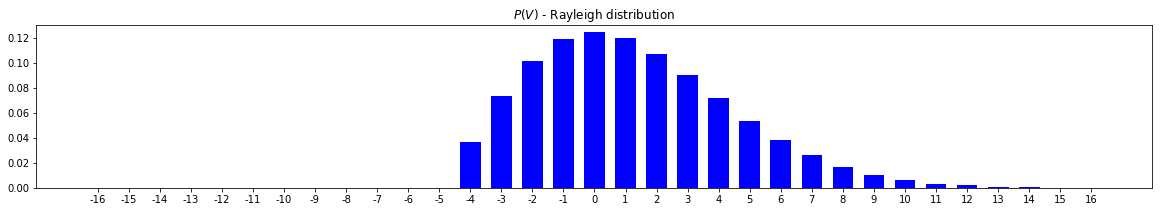

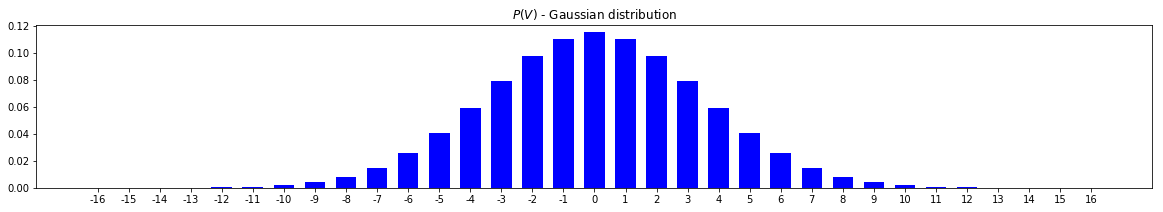

In [4]:
N = 33
center_bin = int((N+1)/2)
scale = 6 # Proportional to variance
## We will use de raileigh
observation_func = get_rayleigh_distribution

observation_1 = get_rayleigh_distribution(N= N, loc = center_bin, scale = scale)
observation_2 = get_gaussian_distribution(N= N, loc = center_bin, scale = scale)
str_indexes_V =  [str(i-center_bin+1) for i in range(N)]
plot_distribution(observation_1, title="$P(V)$ - Rayleigh distribution",str_indexes = str_indexes_V)
plot_distribution(observation_2, title="$P(V)$ - Gaussian distribution",str_indexes = str_indexes_V)

Nuestra observación estara contaminado con ruido con alguna de las distribuciones de la figura superior

Usamos la distribución de Rayleigh como uno de los ejemplos para ver el efecto de la asimetría y observar diferencias entre likelihood y la variable observada $X$

## Distrbución de la observación $X$
$X = S+V$

Supongamos que V tiene distribución de Rayleigh y que estamos en la posición 14

Es deicr, S = 14

Cual es la distribución de X dado que estoy en S=14?

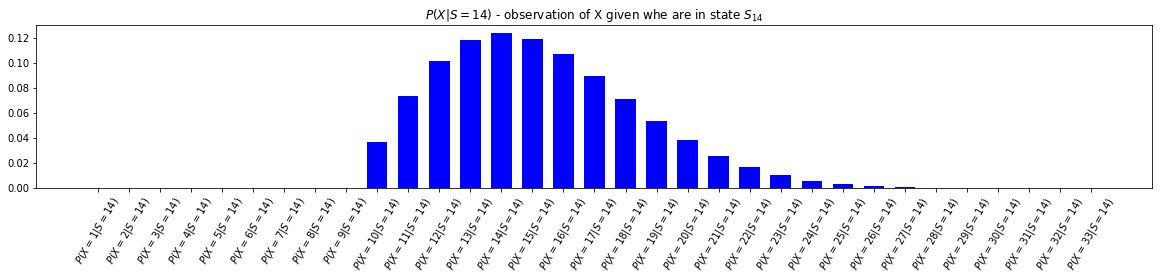

In [5]:
S = 14
observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
str_indexes_observation =  ['$P(X=%s|S=%s)$'%(int(i+1),S) for i in range(N)]
plot_distribution(observation, 
                  title="$P(X|S=%s)$ - observation of X given whe are in state $S_{%s}$"%(S, S),
                 str_indexes= str_indexes_observation, rotation = 60)

In [8]:
observation.sum()

1.0

Es el grafico de arriba el likelihood de $S$?

## $\mathcal{L}(S_k)$ = $P(X=X_o|S_k)$

**No es el likelihood!**

Estamos graficando respecto a los diferentes valores de $X$ y no de los estados $S$.


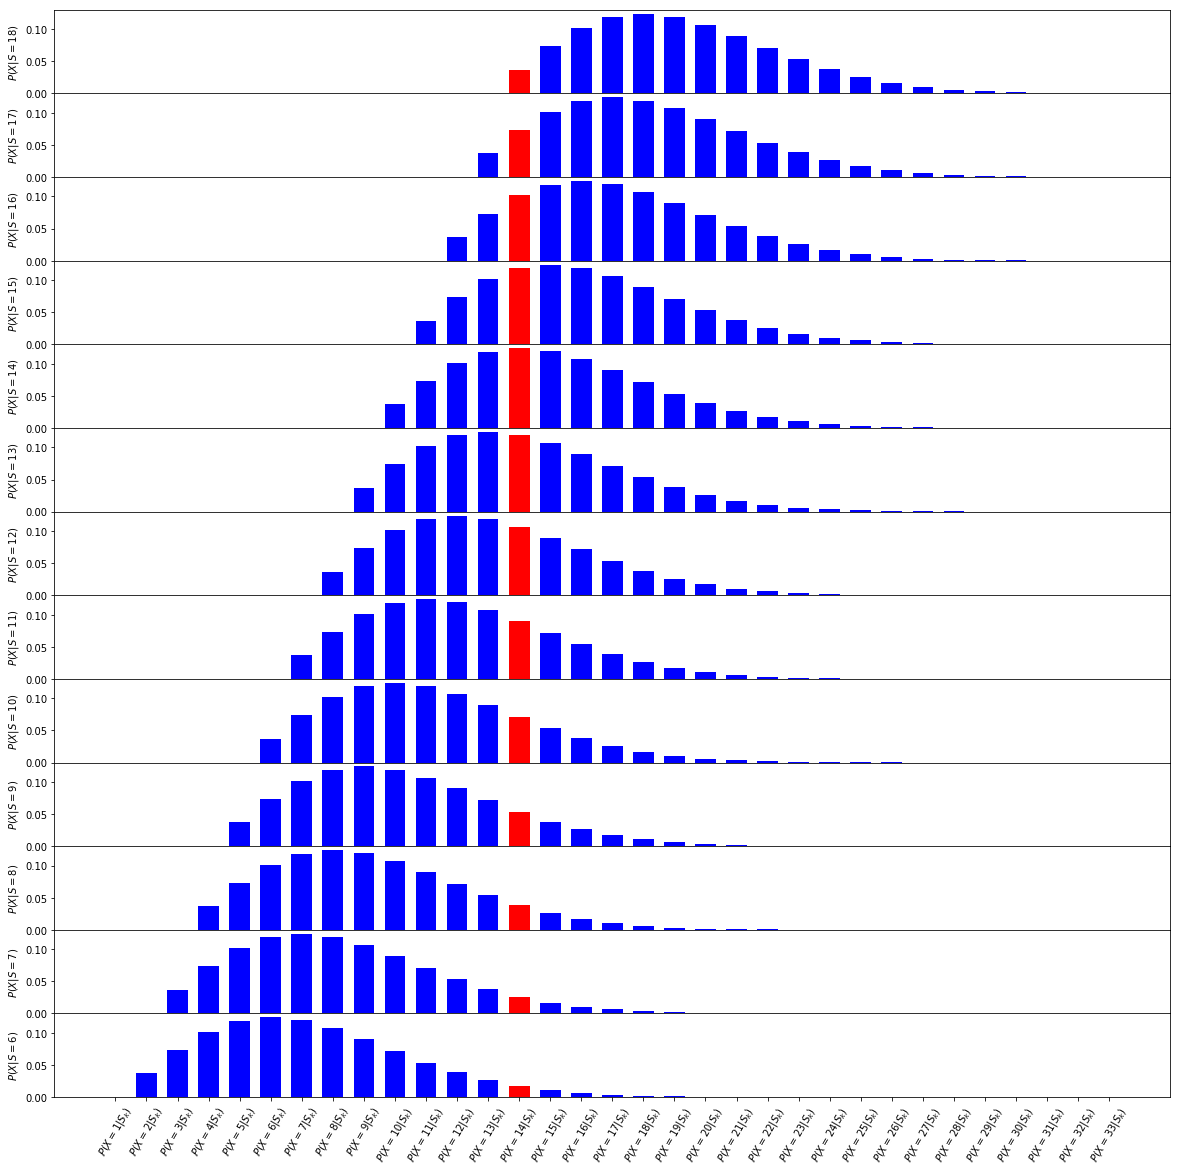

In [6]:
fig = plt.figure(figsize=(20,20))
Ss = [18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
ax = None
fig.subplots_adjust(hspace=0)
str_indexes_observation_n =  ['$P(X=%s|S_k)$'%int(i+1) for i in range(N)]
for i, S in enumerate(Ss):
    observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
    if i == 0:
        ax = plt.subplot(len(Ss),1,i+1)
    else:
        plt.subplot(len(Ss),1,i+1, sharex=ax, sharey=ax)   
    
    title="$P(X|S=%s)$"%(S)
    plt.ylabel(title)
    plot_distribution(observation, 
                  fig = fig,
                     str_indexes = -1, mark = 14)
indexes = np.linspace(1,N,N)
plt.xticks(indexes,str_indexes_observation_n, rotation=60)
plt.show()


## El likelihood $P(X|S_k)$

Dos formas de pensarlo:  
1)  
$P(X=X_i\ |\ S=S_k) = P(S_k + V=X_i\ |\ S_k) = P( V=X_i-S_k\ |\ S_k) $  
Si S_k = X_i posición del máximo de distribución de $V$  
Si partiendo de igualdad aumento S_k, me muevo hacia la izquierda  
Si partiendo de igualdad aumento X_i, me muevo hacia la derecha

2)  
$X(S_k) = S_k + V$  
La distribución de V es constante mientras que la de X es la de V con media en S_k y estoy haciendo la suma de V.A independientes. Estrictamente una convolución entre una "delta" centrada en $S_k$ en el caso continuo y la distribución de $V$. De ahí el hecho de espejar la distribución de $V$

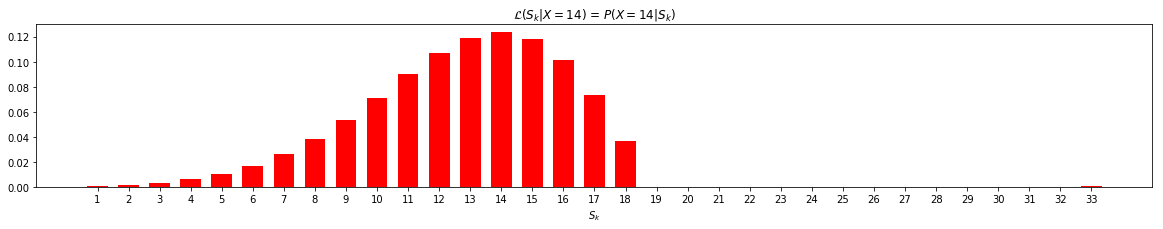

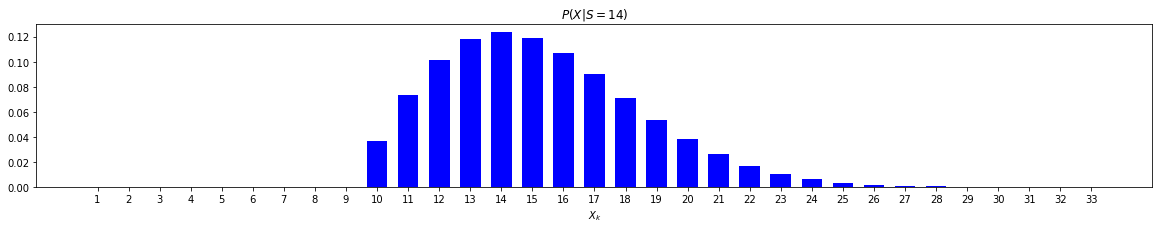

In [11]:
X = 14
S = 14
likelihood = get_likelihood(N, get_rayleigh_distribution, scale = scale)
plot_distribution(likelihood[X], color = 'r', title = "$\mathcal{L}(S_k|X=%s)$ = $P(X=%s|S_k)$"%(X,X))
plt.xlabel('$S_k$')
plt.show()
observation = get_rayleigh_distribution(N= N, loc = S, scale = scale)
plot_distribution(observation, color = 'b', title = "$P(X|S = %s)$"%(X))
plt.xlabel('$X_k$')
plt.show()

La roja es el likelihood, la azul es la distribución de la observación

Notar que como la distribución de la observación X dada la posición es la "misma" (Solo cambia la media) y es aditiva, entonces es equivalente a espejarla para obtener el likelihood. 

Notar que en el ejemplo anterior el dominio de X no se podía sumar a la posición X, no tenia sentido. Era puerta o pared. Es decir no era aditivo

## El update -  $P(S_k|X) = \alpha P(X|S_k)P(S_K)$
Supongamos que tenemos una observación de X = 5

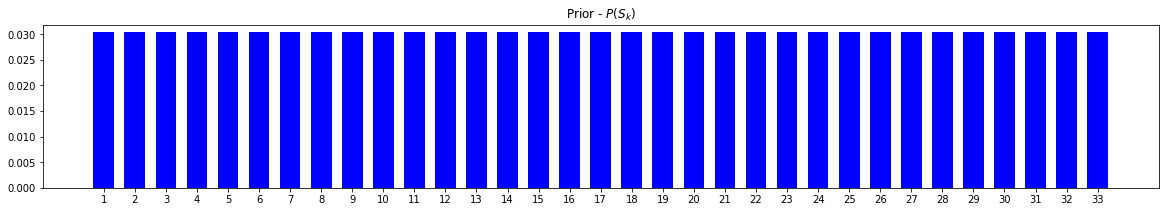

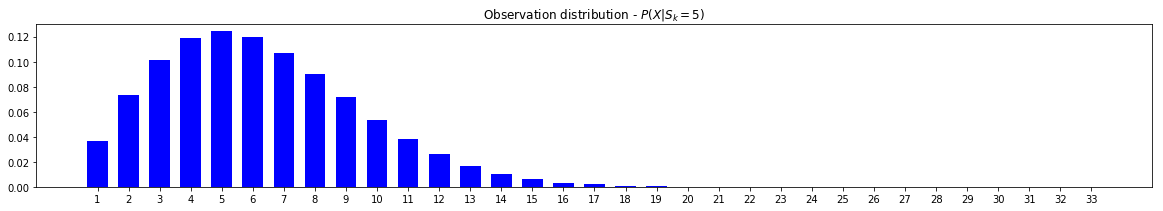

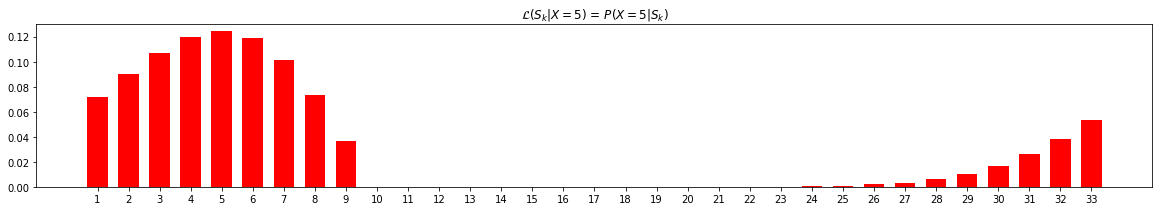

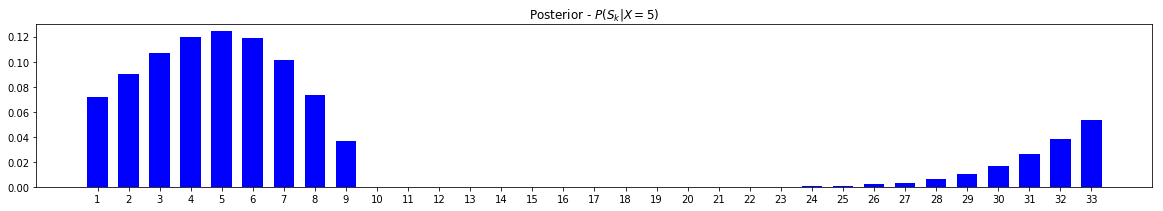

In [12]:
X = 5
p = np.ones(N)/N
posterior = update(p, X, likelihood)
plot_distribution(p, title="Prior - $P(S_k)$")
plot_distribution(observation_func(N= N, loc =X, scale = scale)
                  , title="Observation distribution - $P(X|S_k=%d)$"%X)
plot_distribution(likelihood[X], color = 'r', title = "$\mathcal{L}(S_k|X=%s)$ = $P(X=%s|S_k)$"%(X,X))
plot_distribution(posterior, title="Posterior - $P(S_k|X=%d)$"%X)

## La predicción - $S_{k-1} + W$
**Convolution**

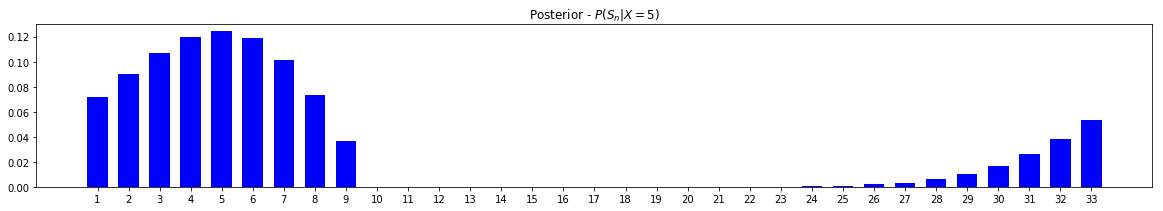

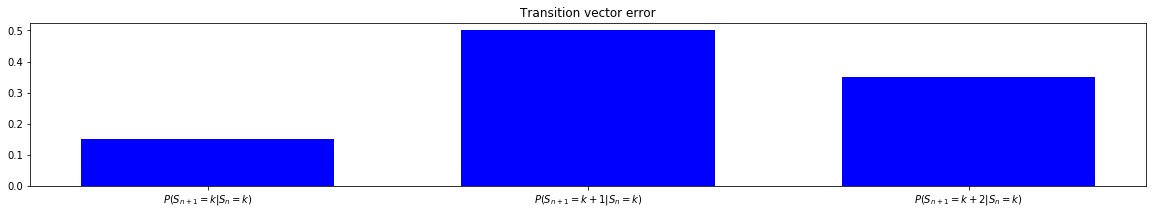

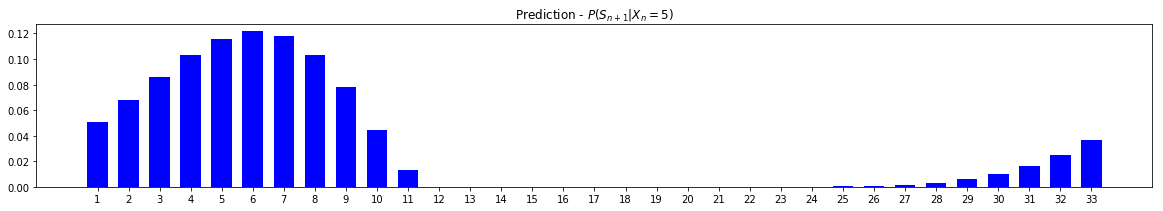

In [13]:
W = np.zeros(3)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35

str_indexes_transition =  ['$P(S_{n+1}=k|S_n=k)$', 
                           '$P(S_{n+1}=k+1|S_n=k)$', 
                           '$P(S_{n+1}=k+2|S_n=k)$']

plot_distribution(posterior, title="Posterior - $P(S_n|X=%d)$"%X)
plot_distribution(W, title="Transition vector error", str_indexes = str_indexes_transition)
predicted = prediction(posterior, W)
plot_distribution(predicted, title="Prediction - $P(S_{n+1}|X_n=%d)$"%X)

# Muestramos modelo generativo y probamos distintos casos

In [14]:
# For all the examples is the same
prior = np.ones(N)/N

In [15]:
def plot_and_get_data(walking_func, observation_func, N=33, steps=20000, S=17, scale=6):
    W = walking_func(N)
    plot_distribution(W, title="Transition")
    likelihood = get_likelihood(N, observation_func, scale=scale)

    measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, 
                                                   W=W, 
                                                   initial_state=S, 
                                                   steps = steps)
    plot_distribution(likelihood[measurements[0]], title="Likelihood - $P(X=%d|S_k)$"%measurements[0])
    robot.plot_robot_room(N = N, loc = loc[-1], sample_stats = sample_stats)
    return measurements, W, likelihood, loc

## Ejemplo 1
- Distribución de Rayleigh
- Caminata como la de la notebook anterior

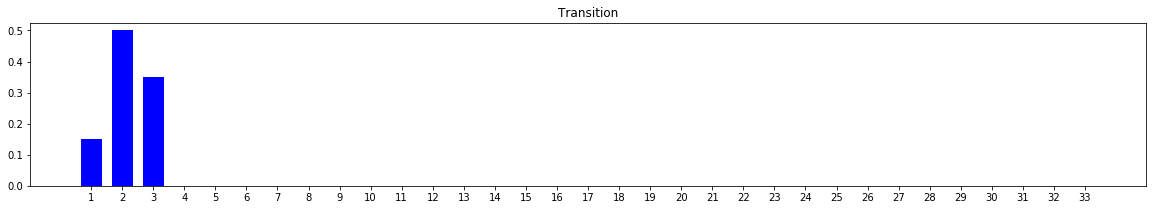

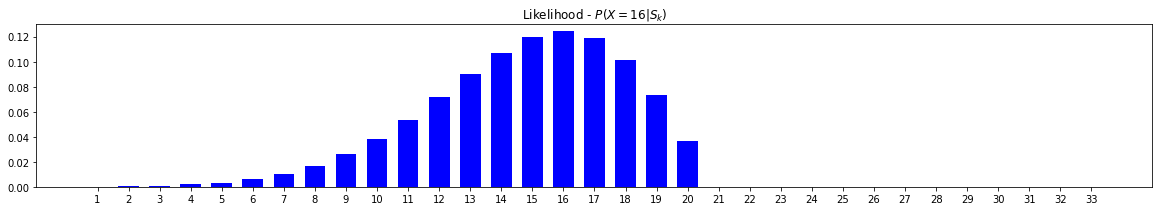

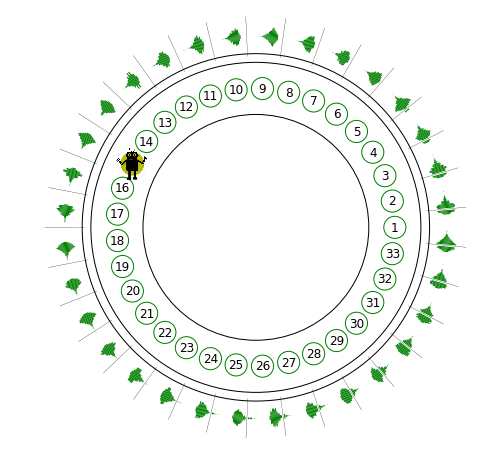

In [16]:
measurements_1, W_1, likelihood_1, loc_1 = plot_and_get_data(get_walking_noise_example_1, get_rayleigh_distribution)

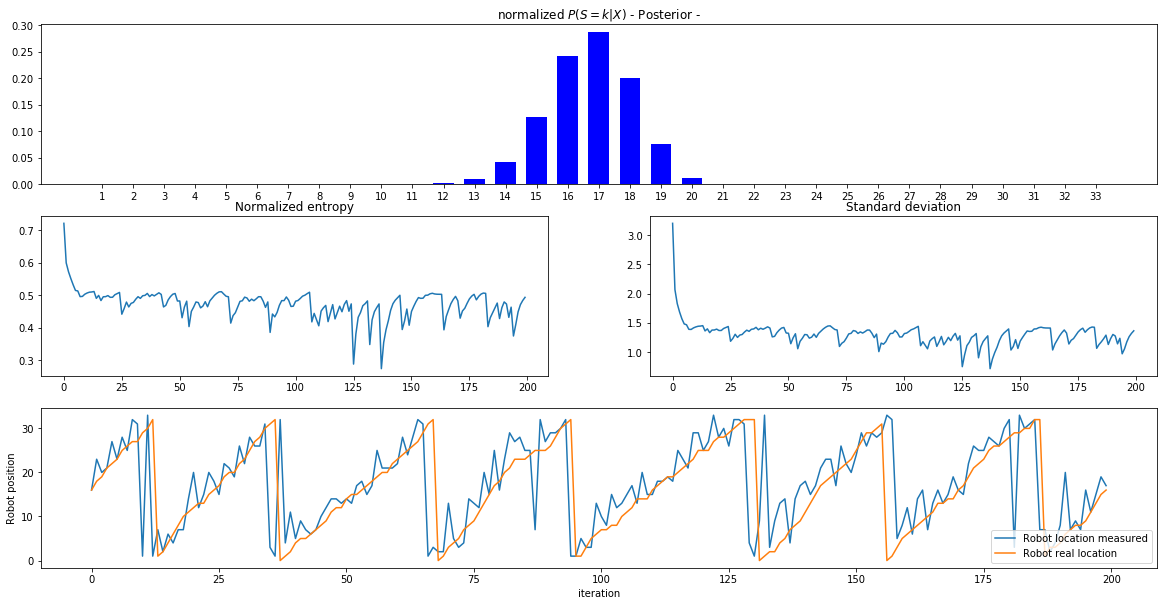

normalized entropy of last posterior: 0.494037158992


In [48]:
#plot_interactive_histogram(measurements_1, W_1, likelihood_1, prior, 2, initial_slider_pos = 1, real_locations=loc_1)
plot_histogram_entropy_std(measurements_1, W_1, likelihood_1, prior, 200, real_positions=loc_1)

## Ejemplo 2
- Distribución de Rayleigh
- Caminata sin error

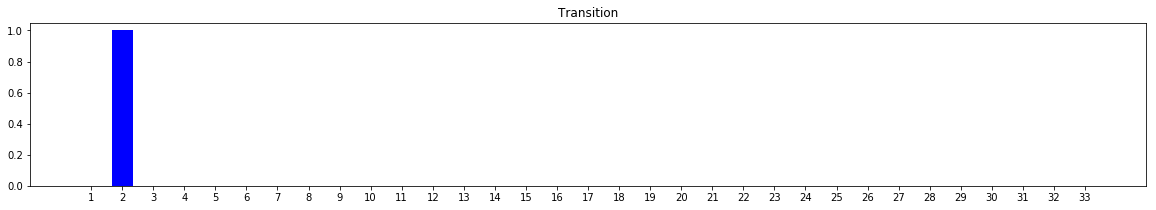

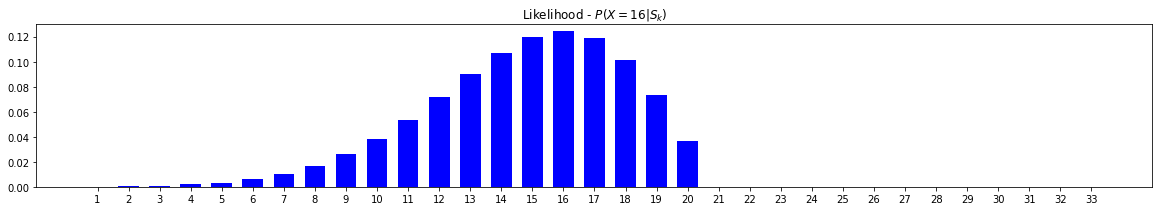

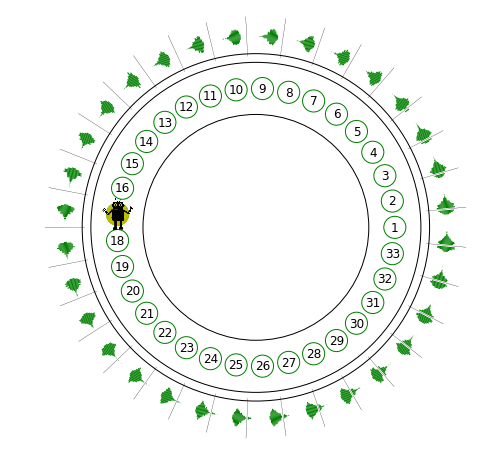

In [47]:
measurements_2, W_2, likelihood_2, loc_2 = plot_and_get_data(get_walking_noise_perfect_1, get_rayleigh_distribution)

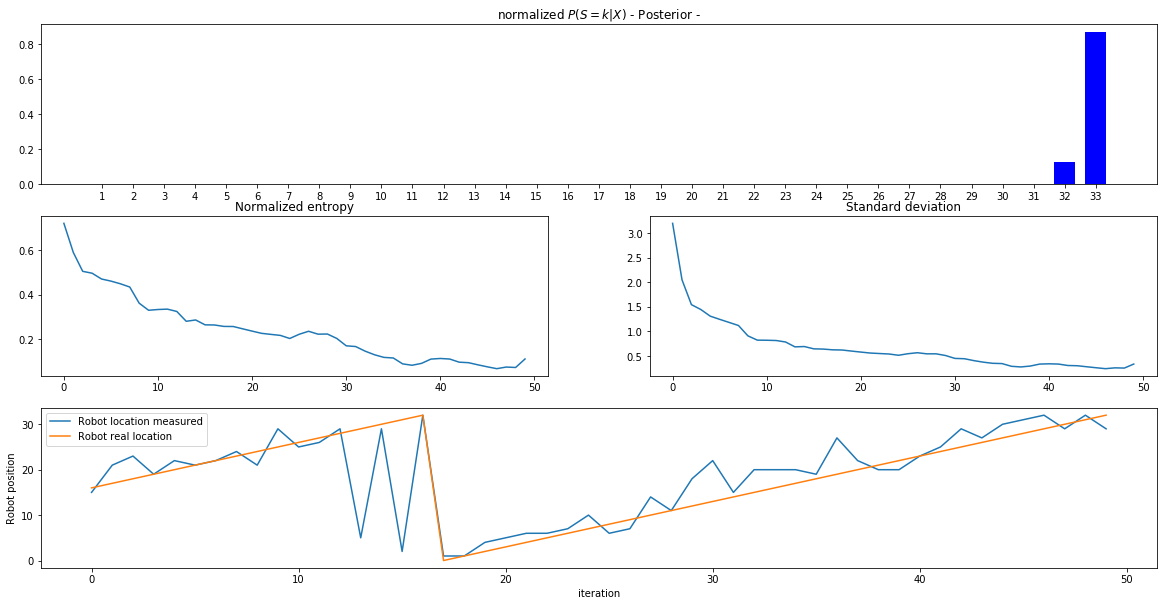

normalized entropy of last posterior: 0.110540618192


In [46]:
plot_histogram_entropy_std(measurements_2, W_2, likelihood_2, prior, 50, real_positions=loc_2)
#plot_interactive_histogram(measurements_2, W_2, likelihood_2, prior, 200, initial_slider_pos = 1, real_locations=loc_2)

## Ejemplo 3
- Distribución de Rayleigh
- El robot "corre" ;)

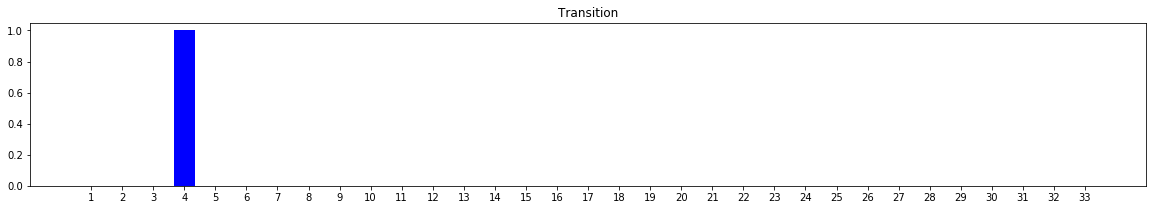

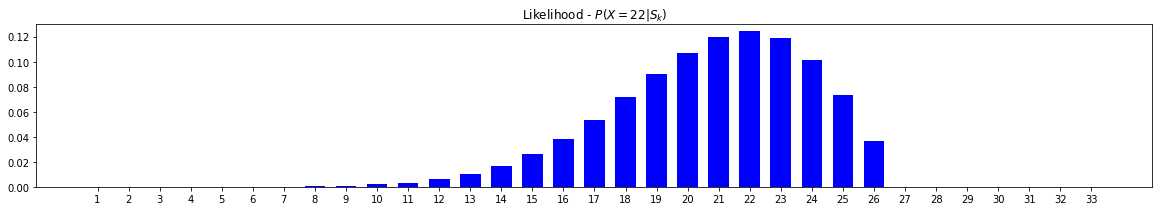

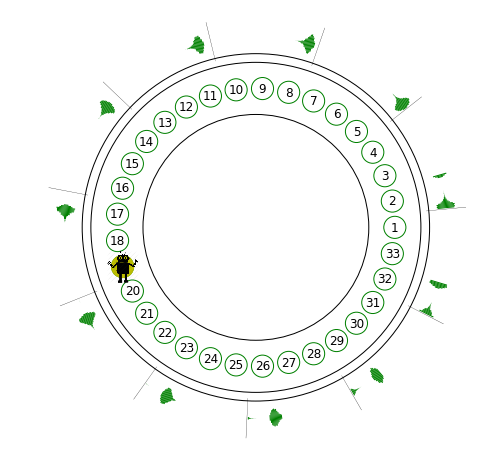

In [33]:
measurements_3, W_3, likelihood_3, loc_3 = plot_and_get_data(get_walking_noise_perfect_3, get_rayleigh_distribution)

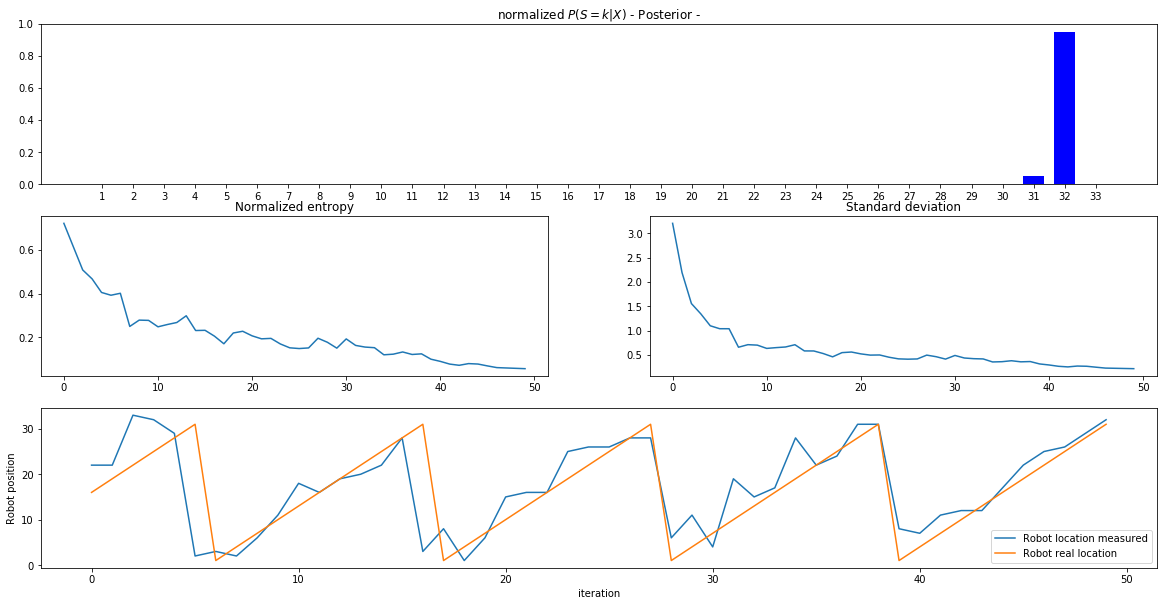

normalized entropy of last posterior: 0.0569297040904


In [45]:
#plot_interactive_histogram(measurements_3, W_3, likelihood_3, prior, 100, 
#                           initial_slider_pos = 1, real_locations=loc_3)
plot_histogram_entropy_std(measurements_3, W_3, likelihood_3, prior, 50, real_positions=loc_3)

## Ejemplo 4. Acercandonos al filtro de Kalman

Una de las caracteristicas principales del filtro de Kalman es que tanto el ruido de observación como el ruido de predicción son Gaussianas con medía cero.  
Armemos el escenario:

**Etapa de predicción** (Additive Gaussian Noise)

$S_{n+1} = S_{n} + 1 + W$ = $S_{n} + W_1$

Notar que W tiene media cero pero $W_1$. Se suma 1 para que $W$ tenga media cero

Podríamos haver sumado cualquier valor en vez de 1? Es la velocidad

**Observation step** (Additive Gaussian Noise)

$X_n = S_n + V$

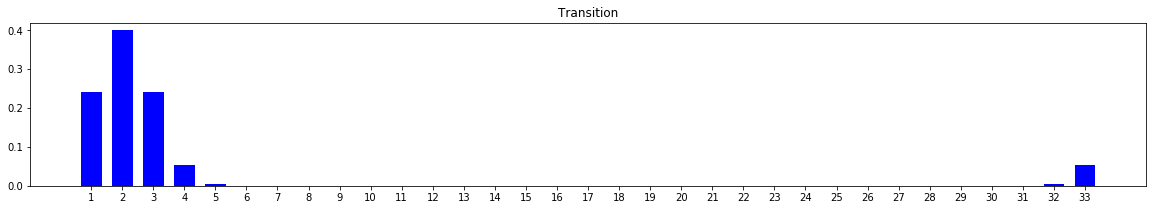

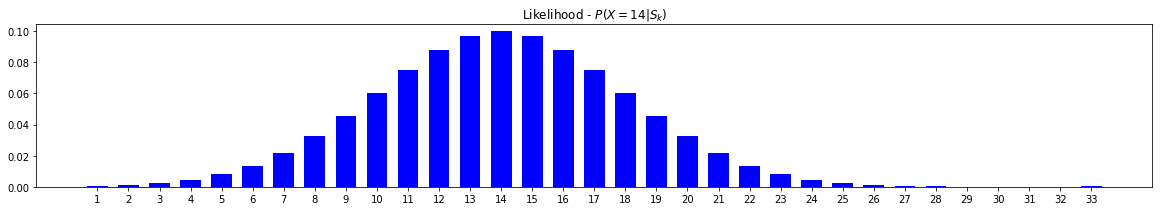

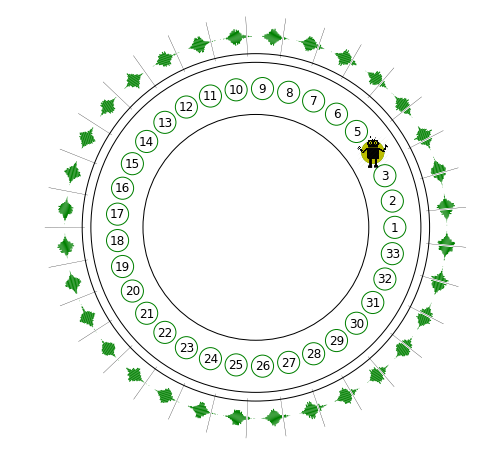

In [37]:
def get_gaussian_prediction(N = 33):
    # This emulates W_1 gaussian random variable with mean = 1
    return get_gaussian_distribution(N=N, loc=2, scale=0.5)


measurements_4, W_4, likelihood_4, loc_4 = plot_and_get_data(get_gaussian_prediction, 
                                                      get_gaussian_distribution, scale=8)

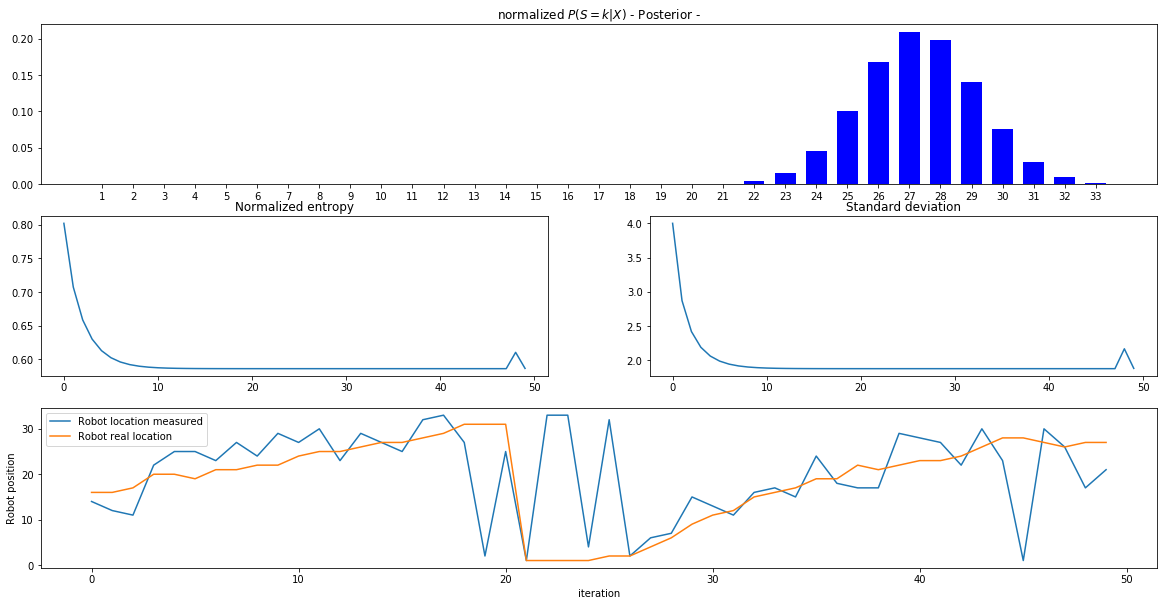

normalized entropy of last posterior: 0.586607177282


In [44]:
plot_histogram_entropy_std(measurements_4, W_4, likelihood_4, prior, 50, real_positions=loc_4)
#plot_interactive_histogram(measurements_4, W_4, likelihood_4, prior, 200, 
#                           initial_slider_pos = 1, real_locations=loc_4)